In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
using Revise
using Plots
using MCMCChains
using StatsPlots

In [3]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_steps.jl")
includet("gibbs_sampler.jl")
includet("gibbs_var_steps.jl")

In [4]:
    true_var_coeff = [.3 .1;  .4 .6]
    true_trend_covariance =  diagm([.02/10, .01/10] .^2) 

    p = -0.7 * .015 * 0.011

    true_cycle_covariance = [(.015)^2 p
                             p (.011)^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [(.015)^2 0
                                      0 (.011)^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    initial_state = [.02, .008]
    true_states, observations= sample(true_model,  [.02, .01, .0, .0], 1600)

    n_presample = 100

    presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

    true_states = true_states[n_presample+1:end,:]
 
  

1500×4 Matrix{Float64}:
  0.00871746  0.00601962  -0.00987699    0.00874453
  0.00616697  0.00624864   0.0047081     0.010026
  0.00568656  0.00658065  -0.0229101     0.0143307
  0.00598703  0.0067964   -0.0327309     0.00544843
  0.00736977  0.00615586  -0.020737      0.00699334
  0.0052288   0.00513606  -0.000670513  -0.0158854
  0.0062716   0.0044686    0.00616947   -0.00248508
  0.00572287  0.00476952  -0.0232724     0.0205325
  0.0116089   0.00580499  -0.00928804    0.00198557
  0.012141    0.00551699   0.0319322    -0.017062
  ⋮                                     
 -0.0646778   0.0107311   -0.00860407   -0.00397984
 -0.0659829   0.00932057  -0.0272898     0.0092352
 -0.068508    0.0107096    0.0122205    -0.0135794
 -0.0698821   0.0098854   -0.0089711     0.00430262
 -0.0704594   0.0113476   -0.0148754     0.0015737
 -0.074125    0.012745    -0.00755324   -0.0123219
 -0.0696895   0.0130845    0.0164352    -0.0221749
 -0.0692002   0.0124076   -0.0330748     0.0110265
 -0.0669523 

In [5]:
display(mean(presample_data[:,1], dims=1)[1])
display(mean(presample_data[:,2] - presample_data[:,1], dims=1)[1])
display(std(presample_data, dims=1))

0.038466306263072736

0.009299593468598705

1×2 Matrix{Float64}:
 0.014479  0.0144266

In [49]:
mean(data, dims=1)

1×2 Matrix{Float64}:
 -0.0921199  -0.0537312

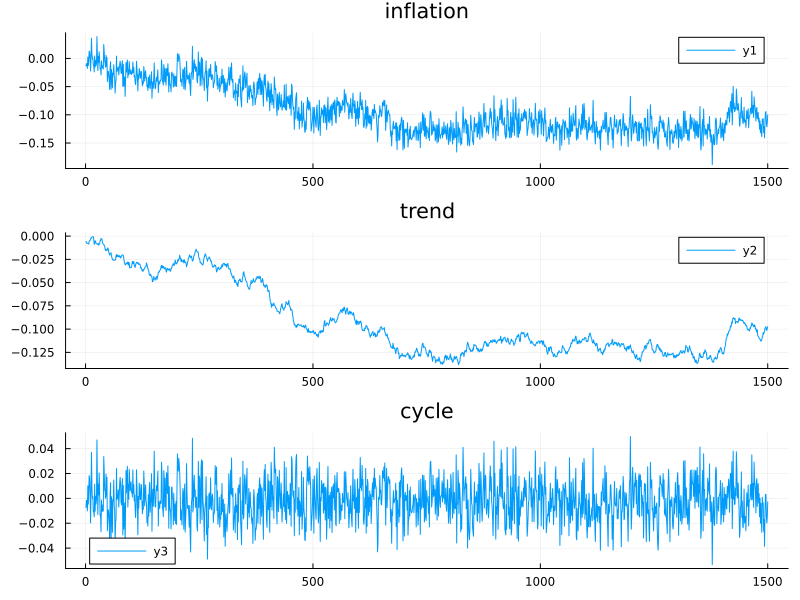

In [50]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

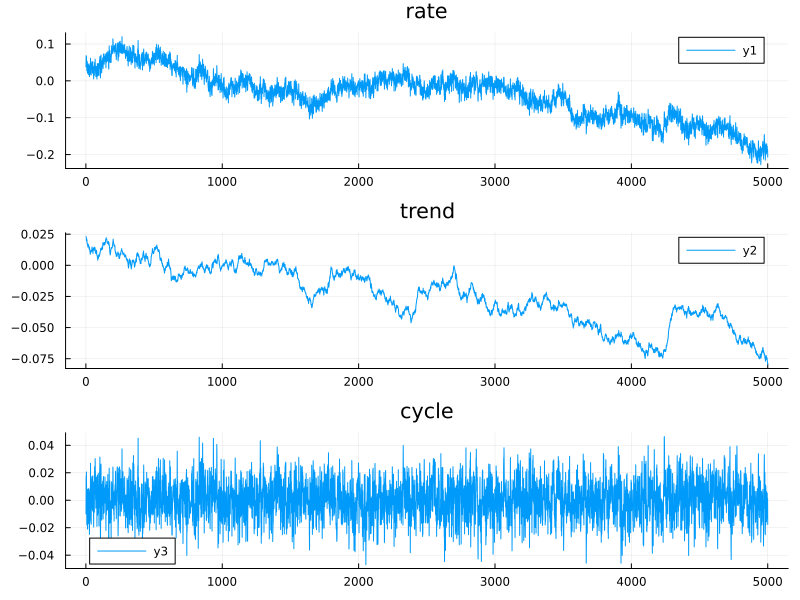

In [8]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [51]:
priors = (
        initial_trend_mean = [mean(presample_data[:,1], dims=1)[1], mean(presample_data[:,2] - presample_data[:,1], dims=1)[1]],
        trend_covariance_df = 100,
        trend_covariance_mean = true_trend_covariance * (100 + 2 +1) #diagm([2, 1].^2/100) * (100 + 2 +1),
        )

(initial_trend_mean = [0.006205926011197546, 0.007769866384952806], trend_covariance_df = 100, trend_covariance_mean = [0.000412 0.0; 0.0 0.000103])

In [52]:
state_smoothed_samples, trend_covariance_samples = gibs_sampler(data, priors, 1_000)

state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  

([-0.00427642629092781 0.014990040420513131 -0.0089898736839261 0.005190721666336899; -0.0038214236630061127 0.015056186326388131 -0.00540437224874589 0.00663013076123023; … ; -0.10596859720850882 0.05668670327070776 -0.007045486430510232 0.0027416378752562784; -0.10449093005509676 0.05693232089906317 0.004388193018798282 0.00949159995044125], [-0.016496787143174138 0.0050265334991513285 -0.019788096224820136 -0.007738887859061656; -0.014930316509112865 0.005458832411408176 -0.01585685077055142 -0.005367511222594464; … ; -0.11553543874913073 0.047257011595965646 -0.017794176460620866 -0.008658383499016485; -0.11454587842050996 0.04724136059614037 -0.005911907565885537 -0.0017058919152215229], [0.00647380725372828 0.025213061119380084 0.003200481683668504 0.017560026837166835; 0.0066151777411417485 0.025032427832546788 0.005692281787770133 0.018719019391643103; … ; -0.09525902187401496 0.06643141295848999 0.002294061236771977 0.013914351857347441; -0.09383916051794379 0.0669189958989652

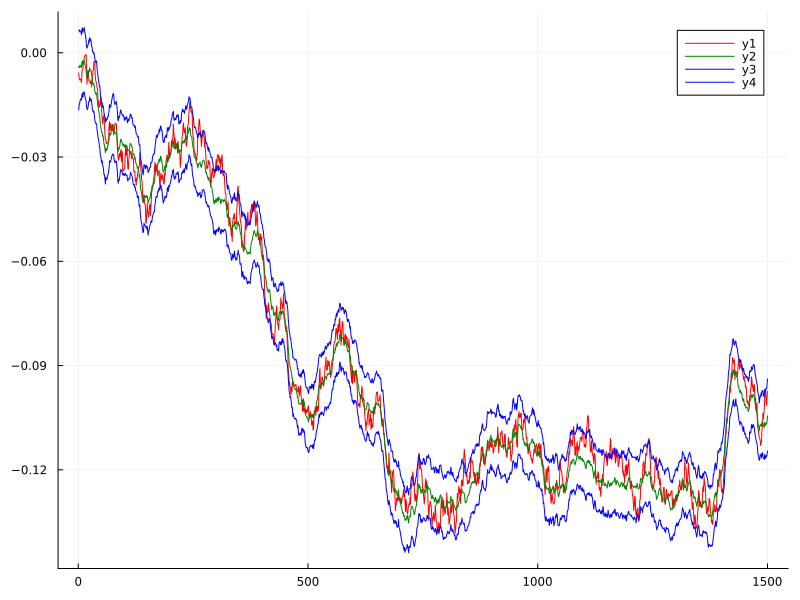

In [53]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

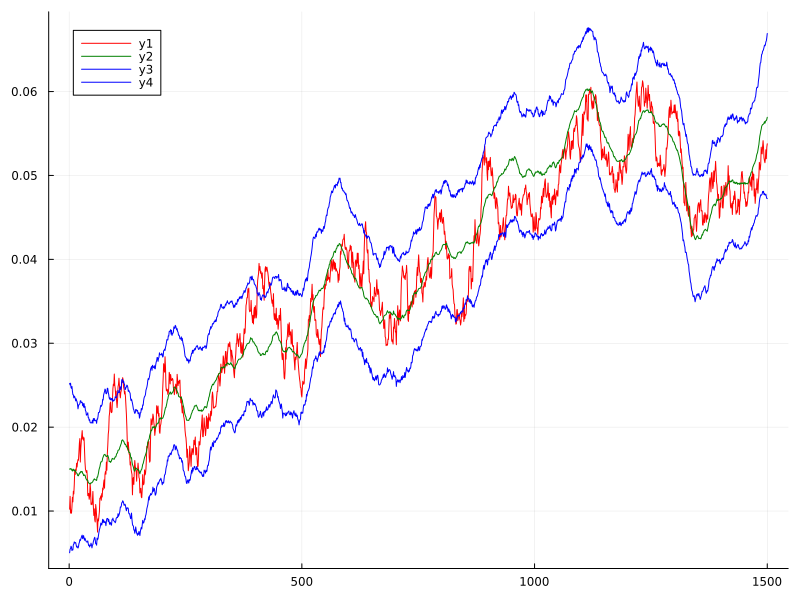

In [54]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

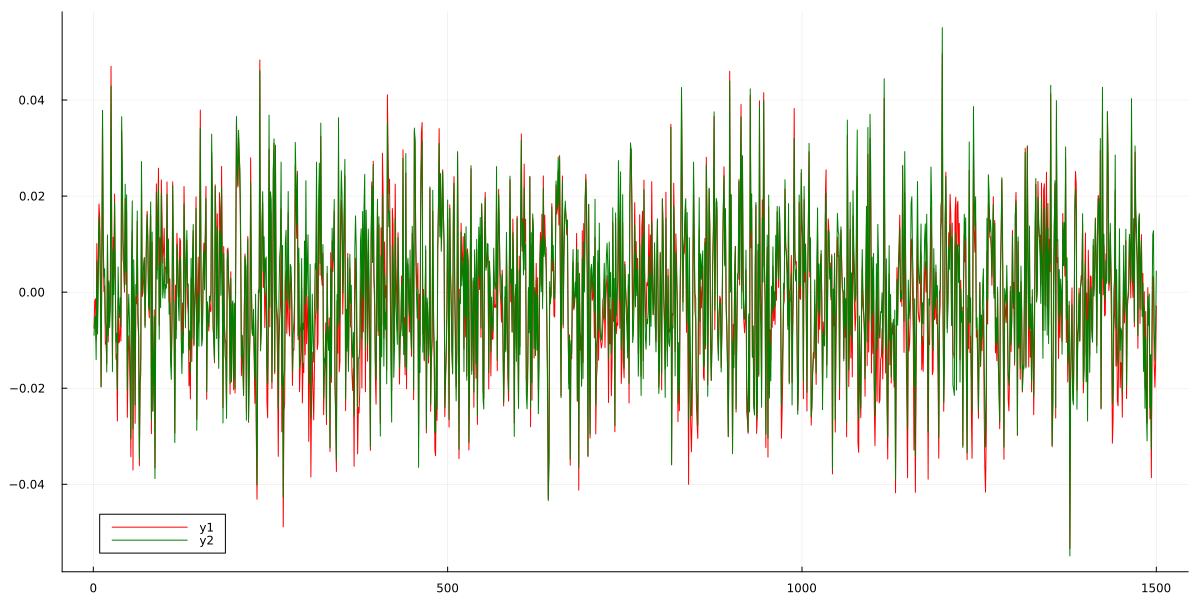

In [55]:
st = 3
plot(true_states[:,st]; color="red", size= (1200, 600))
plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

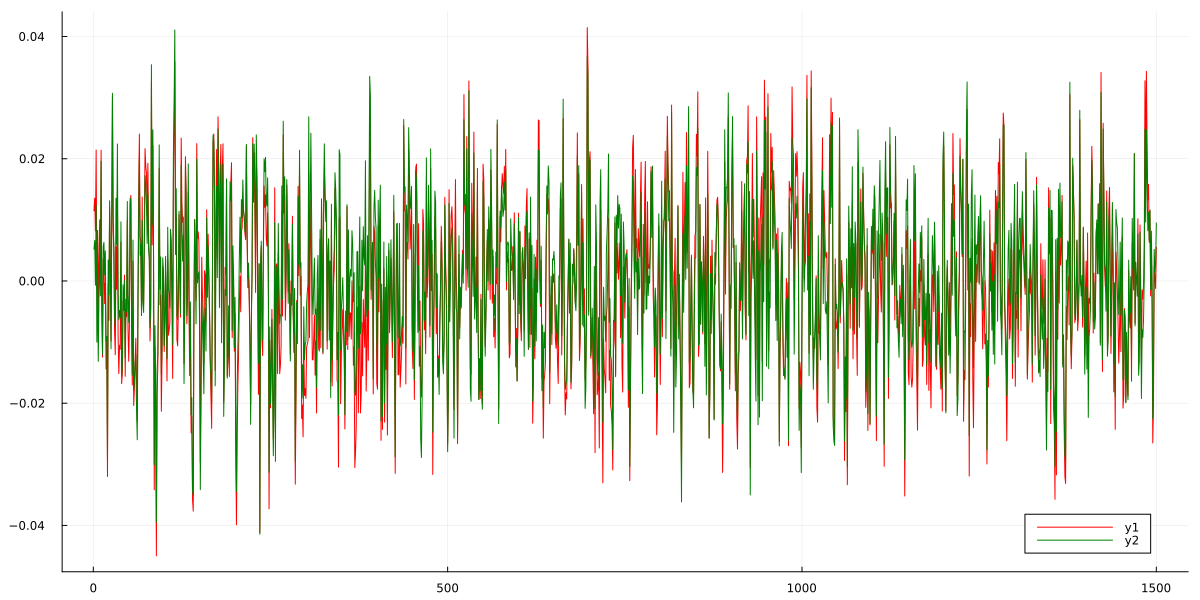

In [57]:
st = 4
plot(true_states[:,st]; color="red", size= (1200, 600))

plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

In [58]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e * 1/(size(Y,1)-1)
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 4.046553748007391e-6
 9.903997165809408e-7

2-element Vector{Float64}:
 0.0020116047693340237
 0.0009951882819752957

In [59]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

       Στ[1]    0.0000    0.0000    0.0000    55.7999   109.6224    1.0063     ⋯
       Στ[2]    0.0000    0.0000    0.0000    63.3118   101.5469    1.0052     ⋯
       Στ[3]    0.0000    0.0000    0.0000    63.3118   101.5469    1.0052     ⋯
       Στ[4]    0.0000    0.0000    0.0000    16.6622    35.7708    1.1079     ⋯
                                                                1 column omitted


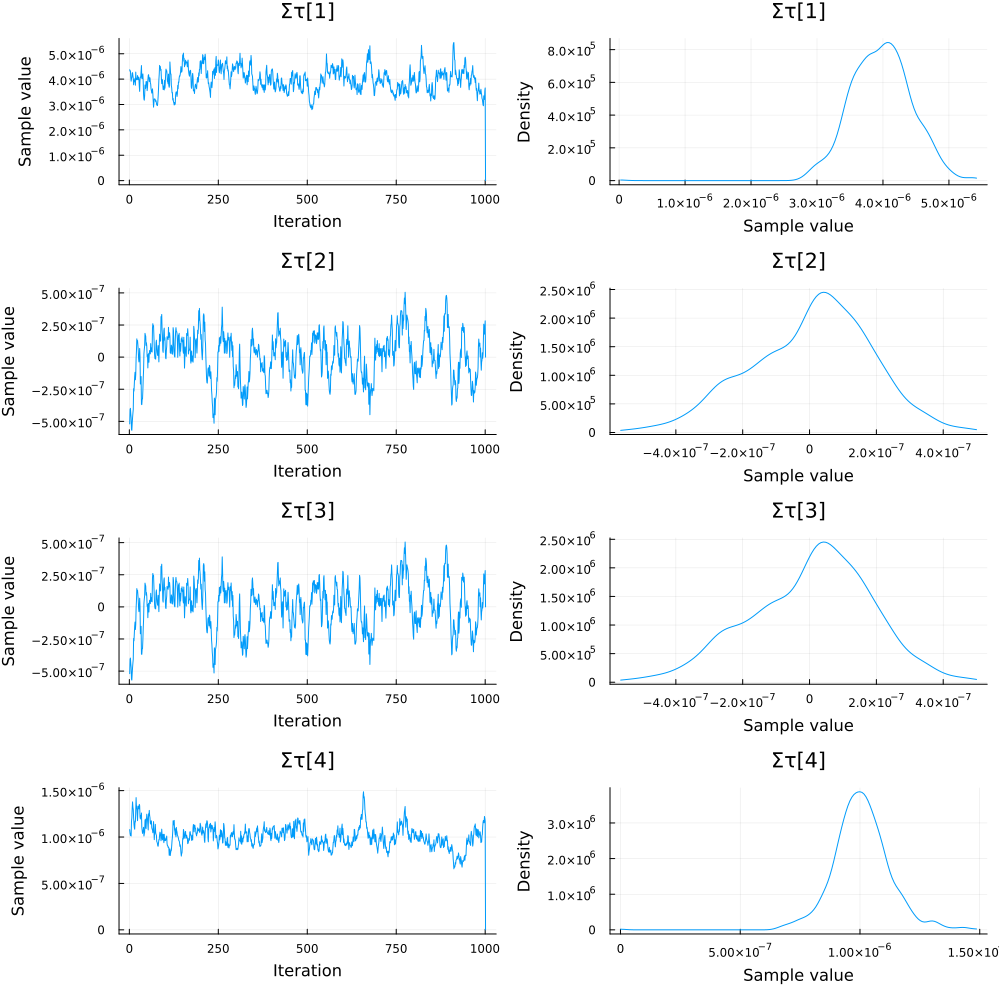

In [60]:
plot(trend_covariance_samples)

In [61]:
beta_mean_prior, beta_var_prior = minnesota_priors([0.015, 0.011] .^.5 , λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])


([0.0, 0.0, 0.0, 0.0], [0.04000000000000001, 0.029333333333333347, 0.05454545454545455, 0.04000000000000001])

In [62]:
d_post = size(data, 1) - 1 + priors.trend_covariance_df

post_dist = covariance_posterior(true_states[:,[1,2]], priors.trend_covariance_mean, d_post)

InverseWishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}}(
df: 1599.0
Ψ: [0.0064777840682630795 -0.00016922782812739; -0.00016922782812739 0.0015876091751548303]
)


In [63]:
true_var + priors.trend_covariance_mean

2×2 Matrix{Float64}:
  0.000416047  -1.12894e-7
 -1.12894e-7    0.00010399

In [64]:
cov_posterior = zeros(10_000, 2)

for n in 1:10_000
  cov_posterior[n,:,:] = diag(rand(post_dist))
end


display(mean(cov_posterior, dims=1) .* 100)
display(mean(cov_posterior, dims=1).^.5 *10) 
display(mode(cov_posterior[1]).^.5 * 10) 
display(mode(cov_posterior[2]).^.5 * 10) 

1×2 Matrix{Float64}:
 0.000405957  9.94743e-5

1×2 Matrix{Float64}:
 0.0201484  0.00997368

0.020104675994817595

0.020417260219856428

In [65]:
diag(true_trend_covariance) .^.5 * 10

2-element Vector{Float64}:
 0.02
 0.01

In [66]:
true_trend_covariance .^.5 .*10

2×2 Matrix{Float64}:
 0.02  0.0
 0.0   0.01

In [67]:
diag(priors.trend_covariance_mean) .^.5 *10

2-element Vector{Float64}:
 0.20297783130184438
 0.10148891565092219

In [68]:
stds = zeros(50_000, 2)


for n in 1:50_000
    stds[n,:] = diag(rand(InverseWishart(priors.trend_covariance_df, priors.trend_covariance_mean)))
end

display(mean(stds, dims=1).^.5 .*10)
display(mode(stds[1]) ^.5 * 10) 
display(mode(stds[2]) ^.5 * 10) 


1×2 Matrix{Float64}:
 0.0206139  0.0103075

0.021347686700771765

0.01865573986789668

In [69]:
stds = std.(eachcol(true_states[:,[3, 4]]))

2-element Vector{Float64}:
 0.015995571627785244
 0.013333151028258447

In [27]:
stds[2]/stds[1] * 0.2

0.16842664811164693

In [70]:
φ, Ω =  minnesota_priors([.015, .011], λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])

display(reshape(φ, 2, 2))

Ω

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0

4-element Vector{Float64}:
 0.04000000000000001
 0.021511111111111113
 0.07438016528925621
 0.04000000000000001

In [71]:
(1 ./ Ω)' *  Ω

4.0

In [72]:
true_var_coeff

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

In [73]:
Y, X = prepare_var_data(true_states[:, [3,4]], 1)

(inv(X'X)*X'*Y)'

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.249427  0.0660376
 0.419512  0.618132

In [74]:
posterior_beta_coefficient(Y, X, reshape(φ, 2, 2), reshape((1 ./ Ω), 2, 2))'

UndefVarError: UndefVarError: `posterior_beta_coefficient` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [33]:
posterior_beta_coefficient(Y, X, reshape(φ, 2, 2), zeros(2,2))'

UndefVarError: UndefVarError: `posterior_beta_coefficient` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [95]:
display(true_var_coeff)
display(true_cycle_covariance)

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

2×2 Matrix{Float64}:
 0.0004  0.0
 0.0     0.0081

In [84]:
T = 1_200

test_var_data = zeros(T, 2)

test_var_data[1,:] = [0., 0.]

for t in 2:T
    test_var_data[t, :] = true_var_coeff * test_var_data[t-1, :] + rand(MvNormal(zeros(2), true_cycle_covariance))
end 

In [91]:
var(test_var_data, dims=1)

1×2 Matrix{Float64}:
 0.000250988  0.00018447

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     param_1    0.2207    0.2642    0.2868    0.3098    0.3557
     param_2   -0.0681   -0.0169    0.0099    0.0359    0.0867
     param_3    0.3267    0.3630    0.3829    0.4003    0.4340
     param_4    0.5481    0.5902    0.6108    0.6322    0.6735


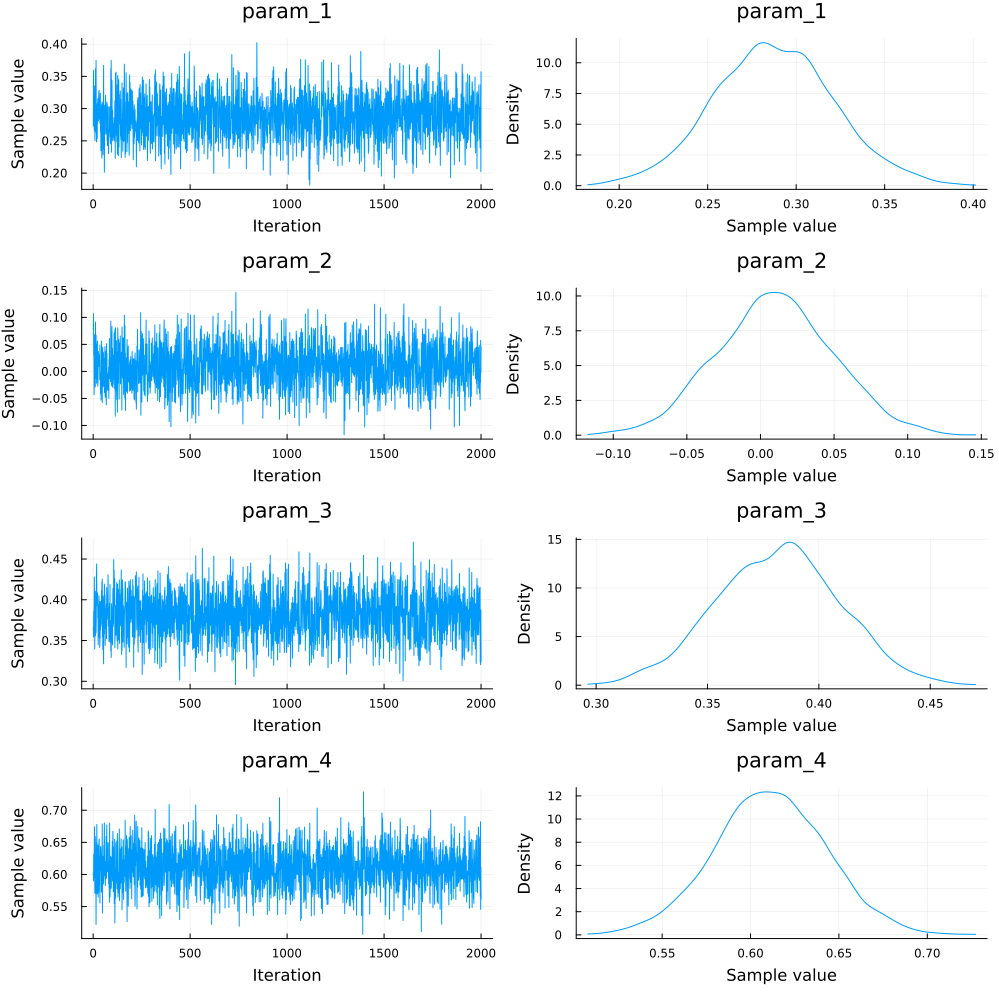

2×2 Matrix{Float64}:
  0.000225   -0.0001155
 -0.0001155   0.000121

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     param_1    0.0002    0.0002    0.0003    0.0003    0.0003
     param_2   -0.0001   -0.0001   -0.0001   -0.0001   -0.0001
     param_3   -0.0001   -0.0001   -0.0001   -0.0001   -0.0001
     param_4    0.0002    0.0002    0.0002    0.0002    0.0002


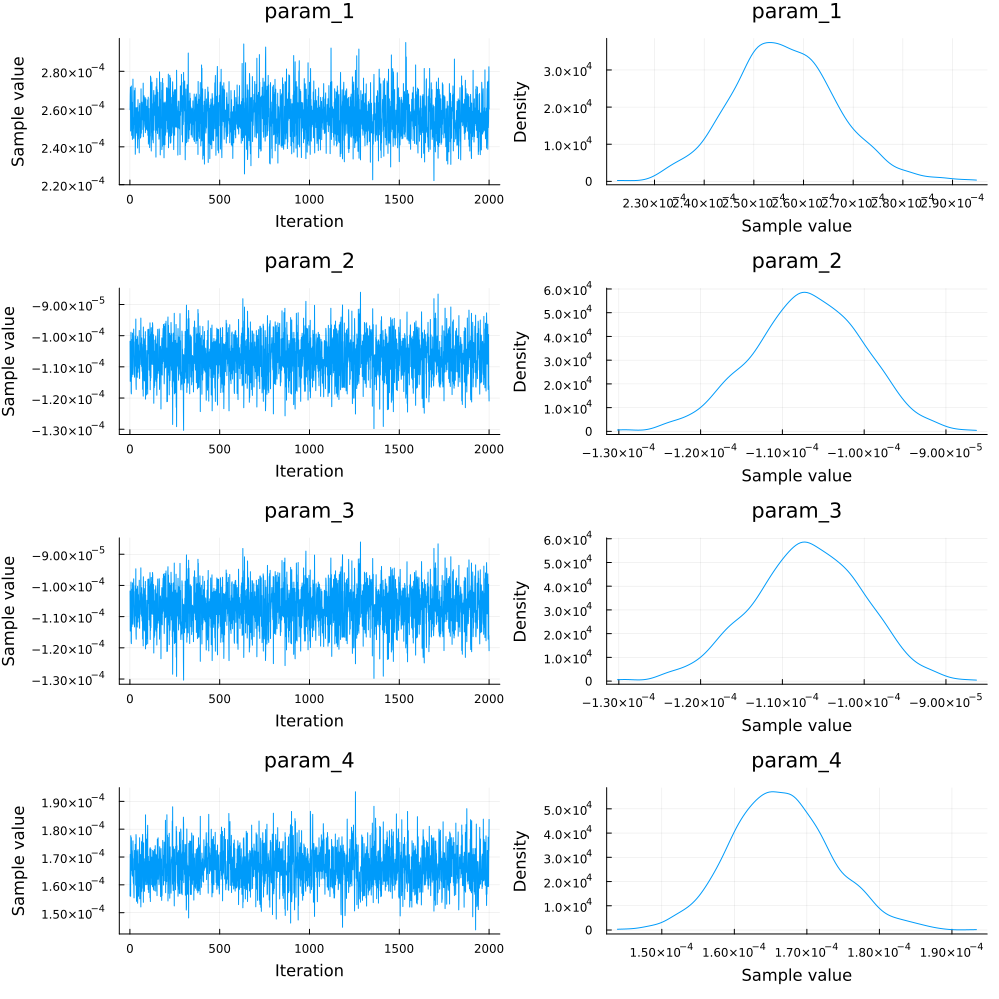

In [ ]:
nc = 2
kc = nc + 2 

variance_prior = (kc + 2 + 1) * [(.015)^2 0
                                 0 (.011)^2
                                ]

λ = .2
Ω = [λ^2, λ^2] ./ diag(prior_var)
Ω = Diagonal(Ω)
Ω_inv = inv(Ω)

n_scenarios = 2_000

betas = zeros(n_scenarios, 4)
sigmas = zeros(n_scenarios, 2, 2)

df = kc + size(test_var_data, 1) - 1

for s in 1:n_scenarios

  betas[s,:], sigmas[s, :, :] = sample_var_params(test_var_data, 1, zeros(2,2), Ω_inv, prior_var, df)
end

chains = Chains(betas)
display(true_var_coeff)
display(quantile(chains))
display(plot(chains))


display(true_cycle_covariance)
chains = Chains(reshape(sigmas, n_scenarios, 4, 1))
display(quantile(chains))

display(plot(chains))

In [99]:
summarystats(chains)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

     param_1    0.0003    0.0000    0.0000   2136.0656   1962.9117    1.0012   ⋯
     param_2   -0.0001    0.0000    0.0000   2051.3517   1755.8243    1.0005   ⋯
     param_3   -0.0001    0.0000    0.0000   2051.3517   1755.8243    1.0005   ⋯
     param_4    0.0002    0.0000    0.0000   1910.4010   1962.7334    1.0010   ⋯
                                                                1 column omitted


In [107]:
mean(get(chains, :param_1).param_1.data) * 100

0.02561049631556582

In [108]:
mean(get(chains, :param_1).param_1.data)  .^ .5

0.01600327976246301

In [109]:
mean(get(chains, :param_4).param_4.data)  .^ .5

0.012901758315082232

In [110]:
mean(get(chains, :param_4).param_4.data) * 100

0.016645536762079353

uncoditional variance

In [113]:
uv = inv(I(4) - kron(true_var_coeff, true_var_coeff)) * vec(true_cycle_covariance)
reshape(uv, 2, 2)

2×2 Matrix{Float64}:
  0.000242794  -9.71144e-5
 -9.71144e-5    0.000176925

In [114]:
kron(I(2), I(2)) * vec(true_cycle_covariance)

4-element Vector{Float64}:
  0.000225
 -0.00011549999999999997
 -0.00011549999999999997
  0.00012099999999999999

In [85]:
uv = inv(I(4) - kron(zeros(2,2), zeros(2,2))) * vec(true_cycle_covariance)

4-element Vector{Float64}:
 0.0004
 0.0
 0.0
 0.0081

In [86]:
kron(zeros(2,2), zeros(2,2))

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0